In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

%run helpFunction.ipynb

\begin{table}
\caption{Test Klassifikations Metriken}
\label{tab:model_performance}
\begin{tabular}{llllr}
\toprule
Modell & Accuracy & Precision & Recall & F1-Score \\
\midrule
ViT & 83% & 83% & 83% & 83.000000 \\
Hybridmodel - ViT - DeiT & 82% & 82% & 82% & 82.000000 \\
Hybridmodel - ViT Lite - DeiT & 82% & 82% & 82% & 82.000000 \\
InceptionV3 & 82% & 83% & 82% & 82.000000 \\
DeiT & 81% & 81% & 82% & 81.000000 \\
ViT Lite & 79% & 79% & 79% & 79.000000 \\
Basic CNN & 78% & 80% & 78% & 78.000000 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/nk/wx0lgww54s34gxbwglwblzyw0000gn/T/ipykernel_58787/671559329.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Modell').apply(lambda x: x.nlargest(1, 'F1-Score')).reset_index(drop=True)


In [2]:
import sys
sys.version

'3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 12:55:12) [Clang 14.0.6 ]'

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [4]:
run = wandb.init(project="VisionTransformer", entity="@ass")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sangeeths-chandrakumar (silvan-wiedmer-fhgr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
# Load Dataset
artifact = run.use_artifact(
    "@ass/VisionTransformer/ecg-image-data-no-preprocessing:v1",
    type="dataset",
)

artifact_dir = artifact.download()

# Get Training Data
training_artifact = np.load(
    os.path.join(artifact_dir, "training-no-preprocessing.npy")
)
training_images = training_artifact["images"]
training_labels = training_artifact["labels"]

# Get Validation Data
validation_artifact = np.load(
    os.path.join(artifact_dir, "validation-no-preprocessing.npy")
)
validation_images = validation_artifact["images"]
validation_labels = validation_artifact["labels"]

# Get Test Data
test_artifact = np.load(os.path.join(artifact_dir, "test-no-preprocessing.npy"))
test_images = test_artifact["images"]
test_labels = test_artifact["labels"]

wandb: Downloading large artifact ecg-image-data-no-preprocessing:v1, 631.56MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.9


(<matplotlib.image.AxesImage at 0x323cd7740>, np.int64(2))

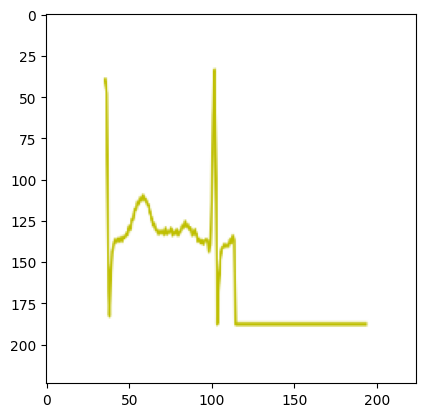

In [6]:
plt.imshow(training_images[0]), training_labels[0]

In [7]:
training_images.shape, test_images.shape, validation_images.shape

((79359, 224, 224, 3), (24799, 224, 224, 3), (19840, 224, 224, 3))

In [8]:
training_labels.shape

(79359,)

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

In [10]:
batch_size = 32

In [11]:
categories = np.unique(training_labels)
training_labels = tf.keras.utils.to_categorical(training_labels, num_classes=len(categories))
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(categories))
validation_labels = tf.keras.utils.to_categorical(validation_labels, num_classes=len(categories))

In [12]:
train_generator = train_datagen.flow(training_images, training_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)
validation_generator = test_datagen.flow(validation_images, validation_labels, batch_size=batch_size)

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])


/Users/sangeeths/miniconda3/envs/deeplearning/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(training_images) // batch_size,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=len(validation_images) // batch_size,
    callbacks=[WandbMetricsLogger()]
)

/Users/sangeeths/miniconda3/envs/deeplearning/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2479/2479 ━━━━━━━━━━━━━━━━━━━━ 495s 200ms/step - accuracy: 0.8533 - loss: 6.1132 - val_accuracy: 0.7694 - val_loss: 0.8650


In [17]:
# Modell evaluieren
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Testgenauigkeit: {test_acc:.4f}, Testverlust: {test_loss:.4f}")

775/775 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.9690 - loss: 0.3757
Testgenauigkeit: 0.7632, Testverlust: 0.8776


In [18]:
wandb.log({'test_loss': test_loss, "test_accc": test_acc})

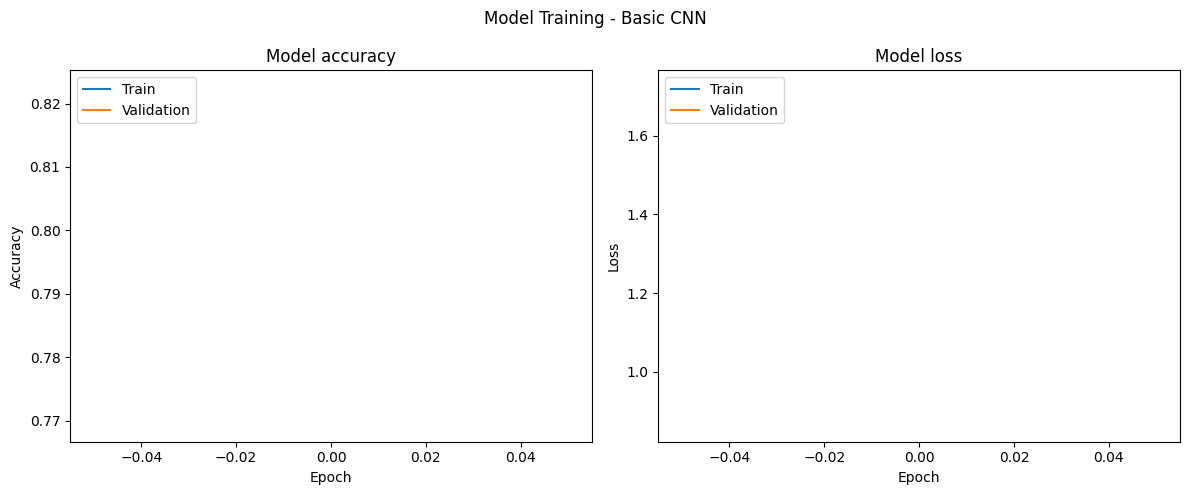

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.suptitle('Model Training - Basic CNN')
plt.tight_layout()
plt.show()


In [70]:
predictions = model.predict(test_images)

775/775 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step


In [71]:
print(test_labels[0])

[0. 0. 1. 0. 0. 0.]


In [72]:
print(predictions[0])

[0.00710504 0.09042407 0.74384606 0.07443979 0.02372642 0.06045866]


In [79]:
def decode_one_hot_labels(labels):
    return np.argmax(labels, axis=1)


[0. 0. 1. 0. 0. 0.]
[0.00710504 0.09042407 0.74384606 0.07443979 0.02372642 0.06045866]
2
2


Error: You must call wandb.init() before wandb.log()

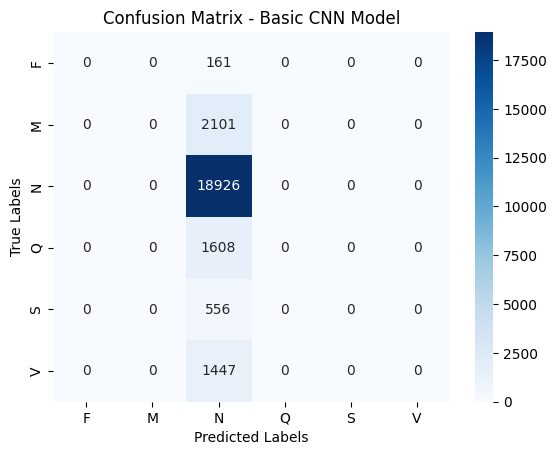

In [76]:
namelabels = {0: 'F', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}

test_labels_decoded = decode_one_hot_labels(test_labels)
predictions_decoded = decode_one_hot_labels(predictions)

print(test_labels[0])
print(predictions[0])
print(test_labels_decoded[0])
print(predictions_decoded[0])

cm = confusion_matrix(test_labels_decoded, predictions_decoded)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=namelabels.values(), yticklabels=namelabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Basic CNN Model')
wandb.log({"confusion-matrix": wandb.Image(plt)})
plt.show()

In [23]:
wandb.finish()

epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
test_accc,▁
test_loss,▁
epoch/accuracy,0.82257
epoch/epoch,0
epoch/learning_rate,0.001
